# Проект для компании «ТелеДом»: предсказание оттока клиентов

## Описание проекта

### Описание задачи и данных

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. 

**Задача бизнеса**

«ТелеДому» нужно сохранить как можно больше клиентов.

**Задача проекта**

Построить модель,которая будет предсказывать, разорвёт ли абонент договор. Для этого необходимо обучить на предоставленных компанией данных модель для прогноза оттока клиентов.

**Описание услуг компании**

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Описание данных**

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Данные состоят из нескольких файлов, полученных из разных источников:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

### Ход исследования 

1. Загрузка данных
- Импорты
- Датасет contract_new.csv
- Датасет personal_new.csv
- Датасет internet_new.csv
- Датасет phone_new.csv
- Загрузка данных: выводы.

2. Предобработка данных
- Работа с оформлением
- Работа с типами данных
- Объединение датасета
- Работа с пропусками
- Работа с дубликатами
- Предобработка данных: выводы.

3. Исследовательский анализ данных
- Создание новых признаков
- Исследование количественных признаков
- Исследование категориальных признаков
- Корреляционный анализ
- Исследовательский анализ данных: выводы.

4. Подготовка данных для обучения
- Отбор признаков для обучения
- Создание выборок
- Пайплайн для подготовки данных
- Подготовка данных для обучения: выводы.

5. Обучение моделей
- LogisticRegression
- LightGBM
- DecisionTreeClassifier
- Обучение моделей: выводы.

6. Тестирование лучшей модели
- Тест модели
- Анализ метрик
- SHAP-анализ признаков
- Тестирование лучшей модели: выводы.

7. Общий вывод

## Загрузка данных

### Импорты

In [1]:
!pip install phik shap scikit-learn==1.6.0 -q
!pip install lightgbm --upgrade -q

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    StandardScaler,
    LabelBinarizer
)
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
import re

sns.set_theme()

In [3]:
RANDOM_STATE = 50525
TEST_SIZE=0.25

### Датасет contract_new.csv

Изучим датасет с информацией о договорах, данные актуальны на 1 февраля 2020 года.

In [4]:
contract = pd.read_csv('/datasets/contract_new.csv')
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


**Описание данных**:
- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора (None в EndDate означает, что клиент ещё имеет договор с компанией);
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

In [5]:
display(contract.info())
display(contract.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


**Комментарий**: По загруженным данным мы видим, что датасет достаточно объёмный (более 7 тысяч записей), очевидных аномалий в MonthlyCharges нет. Не все данные представлены в нужном типе, требуется замена типа данных в следующих признаках:
- BeginDate и EndDate с object на datetime;
- TotalCharges с object на float64.

Тип в PaperlessBilling можно оставить object, требовать bool нет необходимости.  Нет пропусков (есть заглушки на отсутствующие данные). Есть проблема с оформлением - требуется замена на змеиный регистр. 

### Датасет personal_new.csv

Изучим датасет с информацией о персональных данных клиента.

In [6]:
personal = pd.read_csv('/datasets/personal_new.csv')
personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


**Описание данных**:
- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

In [7]:
display(personal.info())
display(personal.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


**Комментарий**: По загруженным данным мы видим, что датасет достаточно объёмный (более 7 тысяч записей), есть очевидные аномалии в SeniorCitizen, так как это бинарный признак и среднее арифметическое не может быть 0.162. Признак SeniorCitizen следует привести к единообразному оформлению (Yes/No), заменить на корректный тип данных (bool или object), как и в других признаках. Нет пропусков. Есть проблема с оформлением - требуется замена на змеиный регистр.

### Датасет internet_new.csv

Изучим датасет с информацией об интернет-услугах. 

In [8]:
internet = pd.read_csv('/datasets/internet_new.csv')
internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


**Описание данных**:
- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSuppot` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

In [9]:
display(internet.info())
display(internet.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,1837-YQUCE,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


**Комментарий**: По загруженным данным мы видим, что датасет достаточно объёмный (более 5 тысяч записей), нет аномальных значений (в бинарных признаках только два значения Yes/No). Все данные представлены в нужном типе. Нет пропусков. Есть проблема с оформлением - требуется замена на змеиный регистр.

### Датасет phone_new.csv

Изучим датасет с информацией об услугах телефонии. 

In [10]:
phone = pd.read_csv('/datasets/phone_new.csv')
phone.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

In [11]:
display(phone.info())
display(phone.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,8974-OVACP,No
freq,1,3390


**Комментарий**: По загруженным данным мы видим, что датасет достаточно объёмный (более 6 тысяч записей), нет аномальных значений (в бинарных признаках только два значения Yes/No). Все данные представлены в нужном типе. Нет пропусков. Есть проблема с оформлением - требуется замена на змеиный регистр.

### Загрузка данных: выводы

<div style="border: 1px solid black; padding: 10px; border-radius: 5px;"> 
По выгруженным датасетам можем сделать следующие выводы:

1. Есть проблемы с оформлением: требуется замена заголовков на корректный змеиный регистр.

2. Все датасеты достаточно объемные, по несколько тысяч записей.

3. Нет пропусков (вероятно, они образуются при объединении датасетов). 

4. Проблемы с аномалиями: есть очевидные аномалии в датасете `personal` в признаке SeniorCitizen, так как это бинарный признак и среднее арифметическое не может быть 0.162. 

5. Не все данные представлены в нужном типе, требуется замена типа данных в:
- датасете `contract`, признаки BeginDate и EndDate: с object на datetime;
- датасете `contract`, признак TotalCharges: с object на float64;
- датасете `personal`, признак SeniorCitizen: с int на bool или object.
    
</div>

## Предобработка данных

На данном этапе исправим некорректное оформление датасетов, объединим их, устраним некорректный тип данных, дубликаты и пропуски. 

### Работа с оформлением

На данном шаге преобразуем некорректное оформление, приведем все колонки к единому регистру.

In [12]:
def convert_columns_to_snake_case(data):
    def to_snake_case(s):
        s = s.strip()
        s = re.sub(r'(?<!^)(?=[A-Z])', '_', s).lower()
        s = re.sub(r'\s+', '_', s)
        s = s.replace('customer_i_d', 'customer_id') 
        return s

    data.columns = [to_snake_case(col) for col in data.columns]
    return data

In [13]:
contract = convert_columns_to_snake_case(contract)
personal = convert_columns_to_snake_case(personal)
internet = convert_columns_to_snake_case(internet)
phone = convert_columns_to_snake_case(phone)
display(contract.head())
display(personal.head())
display(internet.head())
display(phone.head())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Комментарий**: Все 4 датасета приведены к единому оформлению. 

### Работа с типами данных

In [14]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'])
contract['end_date'] = contract['end_date'].replace('No', '2020-02-01')
contract['end_date'] = pd.to_datetime(contract['end_date'])
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')

display(contract.head(10))
display(contract.info())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


None

In [15]:
personal['senior_citizen'] = personal['senior_citizen'].replace({0: 'No', 1: 'Yes'})
personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,No,Yes,No
1,5575-GNVDE,Male,No,No,No
2,3668-QPYBK,Male,No,No,No
3,7795-CFOCW,Male,No,No,No
4,9237-HQITU,Female,No,No,No


**Комментарий:** Заменили в датасетах `contract` и `personal` тип данных на корректный, в датасете personal привели признак senior_citizen к единообразию в оформлении. 

### Объединение датасета

Работа с дубликатами и пропусками в отдельных датасетах не имеет смысла, пока мы не объединим их для сбора всей информации по одному пользователю. 

In [16]:
merged_df = pd.merge(contract, personal, on='customer_id', how='outer')
merged_df = pd.merge(merged_df, internet, on='customer_id', how='outer')
merged_df = pd.merge(merged_df, phone, on='customer_id', how='outer')

display(merged_df.head(10))
display(merged_df.info())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,No,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,No,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,Female,No,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,No,No,Yes,DSL,Yes,Yes,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

None

**Комментарий**: Объединение произошло успешно, все данные сохранены и корректно отображаются: объединение произошло по принципу outer, так как нам важно сохранить информацию о всех клиентах вообще. В датасетах internet и phone информация о некоторых клиентах отсутствует — можем предположить, что, вероятнее всего, клиент соответствующими услугами просто не пользуется, отсюда и пропуски в объединенном датасете. 

### Работа с пропусками

In [17]:
print('Пропуски в merged_df:')
display(merged_df.isnull().sum())

Пропуски в merged_df:


customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_t_v        1526
streaming_movies     1526
multiple_lines        682
dtype: int64

**Комментарий**: Так как в большей степени пропуски в объединенном датасете образовались в связи с тем, что какие-то клиенты явно просто не используют услуги, лучше всего заполнить данные пропуски заглушками. Единственное, явно отличается природа пропусков в total_charges: вероятно, речь идет о клиентах, у которой ещё нет общей суммы трат, возможно, это клиенты, которые только заключили договор. Проверим отдельно строки с этими клиентами.

In [18]:
merged_df[merged_df['total_charges'].isnull()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,No,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,No,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,No,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,No,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,No,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,No,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,No,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,No,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,No,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,Female,No,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


**Комментарий**: Действительно, пропуски связаны с тем, что, вероятно, не получилось высчитать по абонентской месячной плате и по количеству дней общую сумму трат, так как количество дней у только что подключенных клиентов равно нулю. Заполнять прогнозируемым значением, вероятно, некорректно, так как в таком случае нарушится логика и взаимосвязь между количество дней договора и общей суммой трат. В данном случае пропуски логичнее всего заполнить нулем. 

In [19]:
merged_df['total_charges'].fillna(0, inplace=True)

Остальные пропуски заполним заглушками.

In [20]:
def fill_missing_values(df):
    service_columns = [
        'internet_service', 'online_security', 'online_backup',
        'device_protection', 'tech_support', 'streaming_t_v',
        'streaming_movies', 'multiple_lines'
    ]
    
    for column in service_columns:
        df[column].fillna('No service', inplace=True)
    
    return df

In [21]:
merged_df = fill_missing_values(merged_df)
display(merged_df.head())
print('Пропуски в merged_df:')
display(merged_df.isnull().sum())
display(merged_df.info())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,No service
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,No service
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


Пропуски в merged_df:


customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_t_v        0
streaming_movies     0
multiple_lines       0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

None

**Комментарий**: Все пропуски устранены, датасет заполнен. 

### Работа с дубликатами

In [22]:
merged_df.set_index('customer_id', inplace=True)

In [23]:
print('Явные дубликаты в merged_df:', merged_df.duplicated().sum())

Явные дубликаты в merged_df: 4


In [24]:
merged_df = merged_df.drop_duplicates()
merged_df.shape

(7039, 19)

**Комментарий**: Явные дубликаты (4) были удалены из объединенного датасета.

In [25]:
for col in merged_df.select_dtypes(include='object').columns:
    unique_values = merged_df[col].unique()
    print(f"Уникальные значения в колонке '{col}':")
    print(unique_values)

Уникальные значения в колонке 'type':
['Month-to-month' 'One year' 'Two year']
Уникальные значения в колонке 'paperless_billing':
['Yes' 'No']
Уникальные значения в колонке 'payment_method':
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Уникальные значения в колонке 'gender':
['Female' 'Male']
Уникальные значения в колонке 'senior_citizen':
['No' 'Yes']
Уникальные значения в колонке 'partner':
['Yes' 'No']
Уникальные значения в колонке 'dependents':
['No' 'Yes']
Уникальные значения в колонке 'internet_service':
['DSL' 'Fiber optic' 'No service']
Уникальные значения в колонке 'online_security':
['No' 'Yes' 'No service']
Уникальные значения в колонке 'online_backup':
['Yes' 'No' 'No service']
Уникальные значения в колонке 'device_protection':
['No' 'Yes' 'No service']
Уникальные значения в колонке 'tech_support':
['No' 'Yes' 'No service']
Уникальные значения в колонке 'streaming_t_v':
['No' 'Yes' 'No service']
Уникальные значения в колонке 'st

**Комментарий**: Проверив на уникальные значения содержимое признаков типа object, мы тем самым проверили, что в объединенном датасете нет неявных дубликатов и аномальных, неясных категорий. 

### Предобработка данных: выводы

<div style="border: 1px solid black; padding: 10px; border-radius: 5px;"> 

1. Все 4 датасета приведены к единому оформлению, змеиному регистру.
2. Заменили в датасете contract тип данных на корректный, в датасете personal привели признак senior_citizen к единообразию в оформлении.
3. Объединение датасетов в единый произошло успешно, все данные сохранены и корректно отображаются: объединение произошло по принципу outer, так как нам важно сохранить информацию о всех клиентах вообще.
4. Все пропуски устранены, объединенный датасет заполнен. Большинство пропусков в объединенном датасете (признаки 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'multiple_lines') образовались в связи с тем, что часть клиентов не использует услуги, такие пропуски были заполнены заглушками "No service". Природа пропусков в total_charges иная: пропуски были обнаружены у тех клиентов, которые только заключили договор (дата начала договора совпадает с заглушкой актуальной даты выгрузки (1 февраля 2020)). Такие пропуски были заполнены нулем.
5. Явные дубликаты (4) были удалены из объединенного датасета, неявные обнаружены не были.
    
</div>

## Исследовательский анализ данных

### Создание новых признаков

На данном этапе создадим дополнительные признаки, которые могут быть полезны в обучении моделей: срок действия договора в днях и количество подключенных интернет-услуг. Также создадим целевой признак: разорвал абонент договор или нет. 

In [26]:
service_columns = ['online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies']
merged_df['num_of_services'] = merged_df[service_columns].apply(lambda row: row.str.count('Yes').sum(), axis=1)

In [27]:
merged_df['contract_duration_days'] = (merged_df['end_date'] - merged_df['begin_date']).dt.days

In [28]:
merged_df['contract_terminated'] = merged_df['end_date'] != pd.to_datetime('2020-02-01')
merged_df['contract_terminated'] = merged_df['contract_terminated'].map({True: 'Yes', False: 'No'})

display(merged_df.head())
display(merged_df.info())

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,num_of_services,contract_duration_days,contract_terminated
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,...,No,Yes,No,No,No,No,No service,1,31,No
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,No,No,...,Yes,No,Yes,No,No,No,No,1,1036,No
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,...,Yes,Yes,No,No,No,No,No,1,123,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,...,Yes,No,Yes,Yes,No,No,No service,2,1371,No
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,...,No,No,No,No,No,No,No,0,153,No


<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   begin_date              7039 non-null   datetime64[ns]
 1   end_date                7039 non-null   datetime64[ns]
 2   type                    7039 non-null   object        
 3   paperless_billing       7039 non-null   object        
 4   payment_method          7039 non-null   object        
 5   monthly_charges         7039 non-null   float64       
 6   total_charges           7039 non-null   float64       
 7   gender                  7039 non-null   object        
 8   senior_citizen          7039 non-null   object        
 9   partner                 7039 non-null   object        
 10  dependents              7039 non-null   object        
 11  internet_service        7039 non-null   object        
 12  online_security         7039 non-null 

None

**Комментарий**: Признаки добавлены корректно с нужным типом данных. 

### Исследование количественных признаков

Исследование признаков будет в разрезе целевого: разорвал клиент договор или нет. На данном этапе изучим количественные признаки: monthly_charges, total_charges, num_of_services, contract_duration_days.

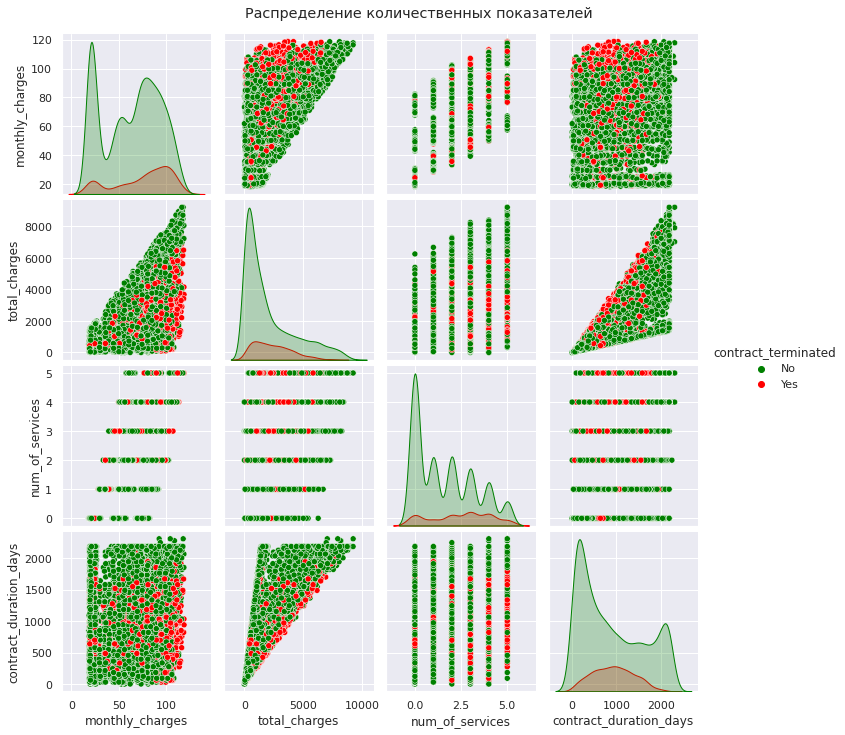

In [29]:
sns.pairplot(
    merged_df,
    vars=['monthly_charges', 'total_charges', 'num_of_services', 'contract_duration_days'],
    hue='contract_terminated',
    palette={'Yes': 'red', 'No': 'green'}
)

plt.suptitle('Распределение количественных показателей', y=1.02)
plt.show()

**Комментарий**: 
1. ***Месячные расходы (montly_charges)***: клиенты с высокими месячными расходами (выше 60) чаще остаются, и, наоборот, клиенты, разрывающие договор, чаще имеют более низкие месячные расходы.
   
2. ***Общие расходы (total_charges)***: те, у кого высокие общие расходы, чаще остаются - вероятно, это связано с тем, что они дольше времени пользуются услугами.

3. ***Количество услуг (num_of_services)***: те, кто использует меньше услуг (1-2), могут быть более склонны к разрыву, с увеличением же количества используемых услуг вероятность остаться увеличивается.

4. ***Продолжительность контракта (contract_duration_days)***: долгосрочные клиенты (более 1000 дней) чаще остаются, что указывает на лояльность, а новые клиенты чаще разрывают договор, что может сигнализировать о неудовлетворенности.

### Исследование категориальных признаков

На данном этапе изучим количественные признаки:  type, paperless_billing, payment_method, gender, senior_citizen, partner, dependents, internet_service, online_security, online_backup, device_protection, tech_support, streaming_t_v, streaming_movies, multiple_lines.      

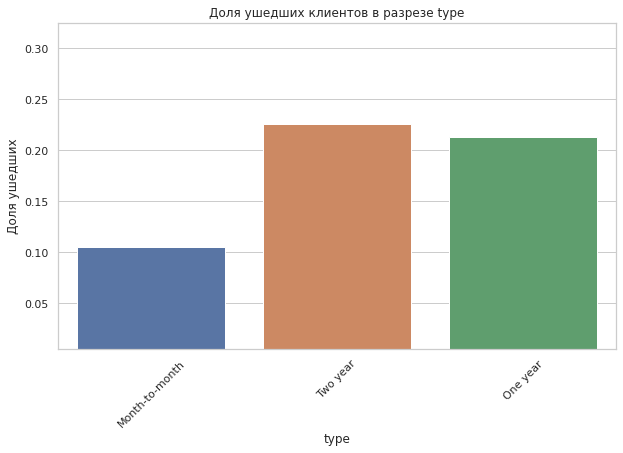


Таблица долей ушедших клиентов для type:


,type,terminated_ratio
1,Two year,0.225044
2,One year,0.212492
0,Month-to-month,0.105086


In [30]:
#для удобства создадим функцию, чтобы рассчитывать доли ушедших клиентов по заданному категориальному признаку
def plot_terminated_ratios(data, category_column):
    
    #подсчет общего количества клиентов по заданному признаку 
    total_counts = data[category_column].value_counts()
    terminated_counts = data[data['contract_terminated'] == 'Yes'][category_column].value_counts()

    #вычисление доли ушедших клиентов
    terminated_ratio = terminated_counts / total_counts

    terminated_ratio_df =  terminated_ratio.reset_index()
    terminated_ratio_df.columns = [category_column, 'terminated_ratio']

    plt.figure(figsize=(10, 6)) 
    sns.set(style='whitegrid')
    ax = sns.barplot(x=category_column, y='terminated_ratio', data=terminated_ratio_df, ci=None)
    ax.set_ylim(terminated_ratio_df['terminated_ratio'].min() - 0.1, terminated_ratio_df['terminated_ratio'].max() + 0.1)
    plt.ylabel('Доля ушедших')
    plt.title(f'Доля ушедших клиентов в разрезе {category_column}')
    plt.xticks(rotation=45)
    plt.show()
    
    #вывод таблицы
    print(f"\nТаблица долей ушедших клиентов для {category_column}:")
    display(terminated_ratio_df.sort_values(by='terminated_ratio', ascending=False))
    
plot_terminated_ratios(merged_df, 'type')

**Комментарий**: 
1. Two year: самая высокая доля ушедших клиентов — 22.5%, что может указывать на трудности с удержанием клиентов на более длительных контрактах.

2. One year: доля ушедших немного ниже, чем у двухлетних контрактов, что тоже может свидетельствовать о схожих проблемах с удержанием клиентов при длительных обязательствах.

3. Month-to-month: самая низкая доля ушедших клиентов, так что, вероятно, клиенты, выбирающие эту опцию, как правило, остаются дольше, возможно из-за гибкости и отсутствия долгосрочных обязательств.

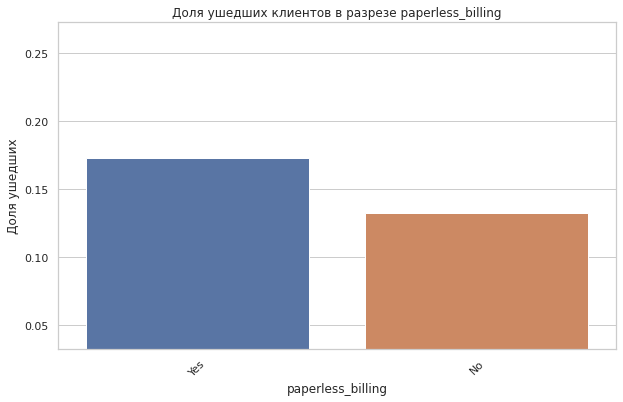


Таблица долей ушедших клиентов для paperless_billing:


,paperless_billing,terminated_ratio
0,Yes,0.172902
1,No,0.132450


In [31]:
plot_terminated_ratios(merged_df, 'paperless_billing')

**Комментарий**:  Можем сделать вывод, что клиенты, которые не пользуются электронными расчетными листами, уходят реже. Но разница в долях небольшая, и, вероятно, значимость признака при обучении модели будет не сильно большая, это явно не решающий фактор для ухода клиента. 

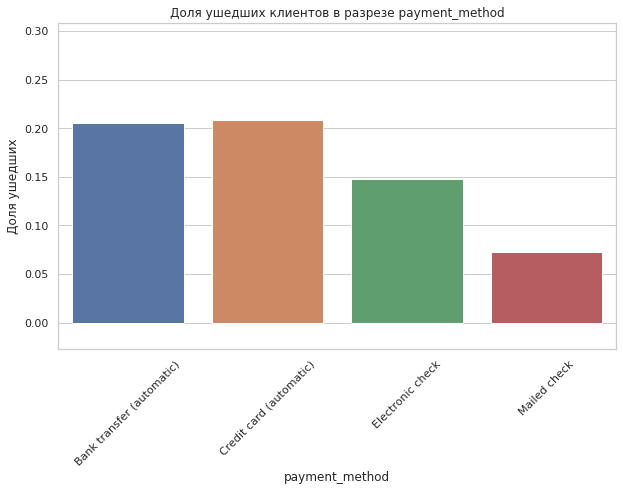


Таблица долей ушедших клиентов для payment_method:


,payment_method,terminated_ratio
1,Credit card (automatic),0.208416
0,Bank transfer (automatic),0.205311
2,Electronic check,0.147992
3,Mailed check,0.072716


In [32]:
plot_terminated_ratios(merged_df, 'payment_method')

**Комментарий**: 
1. Доля ушедших наиболее высокая при способах Credit card (automatic) и Bank transfer (automatic) — около 20.8% и 20.5% соответственно. Это может указывать на неудобства или другие факторы, связанные с автоматическими платежами. Люди, использующие автоматические платежи, могут чаще уходить, возможно, из-за отсутствия контроля над оплатами.

2. Электронный чек имеет лучшую удерживаемость по сравнению с автоматическими платежами.

3. Самая низкая доля ушедших клиентов — 7.3% — Mailed check, то есть почтовый чек. Возможно, клиенты, выбирающие этот способ, более консервативны и имеют высокую лояльность.  Способ хоть и менее удобен, но, получается, может свидетельствовать о более стабильной клиентской базе.

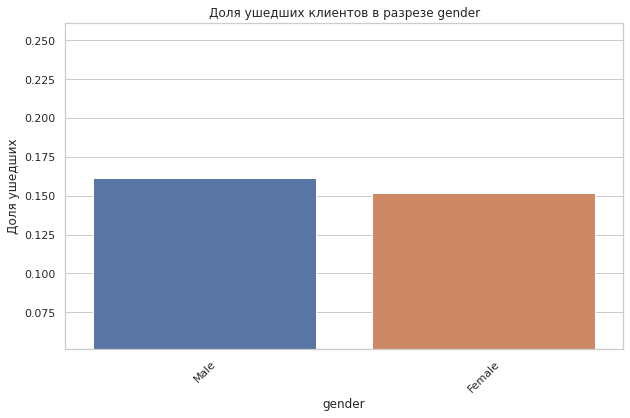


Таблица долей ушедших клиентов для gender:


,gender,terminated_ratio
0,Male,0.161318
1,Female,0.151420


In [33]:
plot_terminated_ratios(merged_df, 'gender')

**Комментарий**: По графику видим, что серьезной корреляции между полом и уходом клиента нет, признак значимости не имеет. 

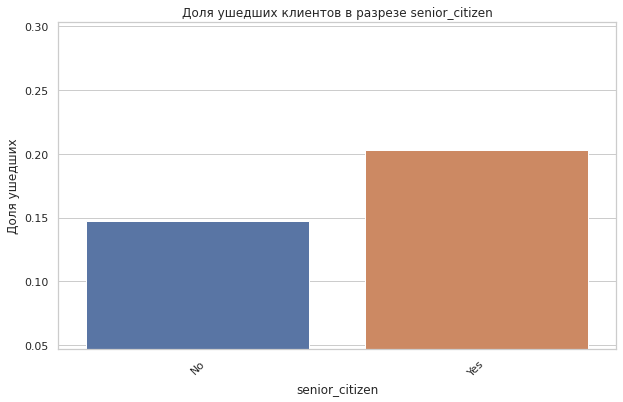


Таблица долей ушедших клиентов для senior_citizen:


,senior_citizen,terminated_ratio
1,Yes,0.203152
0,No,0.147363


In [34]:
plot_terminated_ratios(merged_df, 'senior_citizen')

**Комментарий**: Пенсионеры имеют более высокую долю оттока. Возможно, это связано с финансовыми или технологическими факторами.

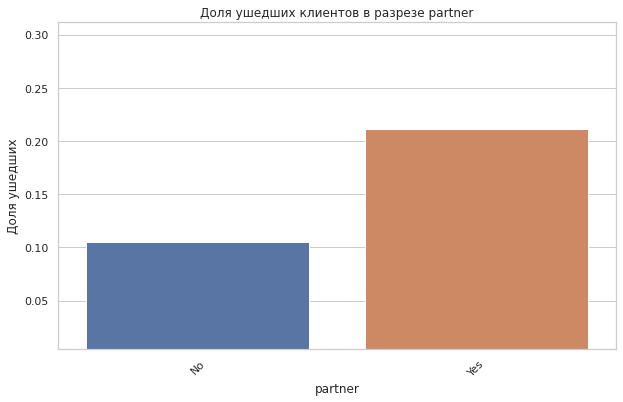


Таблица долей ушедших клиентов для partner:


,partner,terminated_ratio
1,Yes,0.211471
0,No,0.104974


In [35]:
plot_terminated_ratios(merged_df, 'partner')

**Комментарий**: Наличие партнера связано с более высокой долей оттока. Возможно, это связано с семейными обстоятельствами, финансовыми обязательствами по отношению к другим членам семьи. 

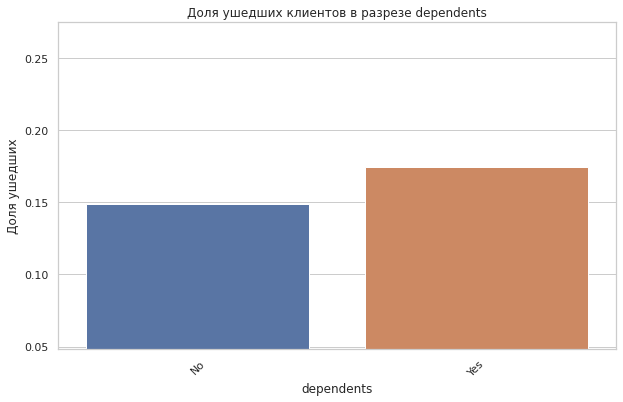


Таблица долей ушедших клиентов для dependents:


,dependents,terminated_ratio
1,Yes,0.174490
0,No,0.148682


In [36]:
plot_terminated_ratios(merged_df, 'dependents')

**Комментарий**: Аналогично с наличием партнера, финансовыме и семейные обязательства повышают вероятность ухода клиента. Пусть разница и не значительна между теми, у кого есть иждивендцы, и у кого нет, но она есть. 

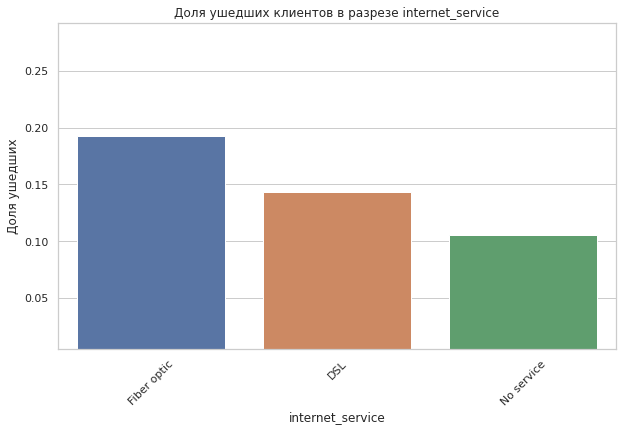


Таблица долей ушедших клиентов для internet_service:


,internet_service,terminated_ratio
0,Fiber optic,0.192246
1,DSL,0.142916
2,No service,0.105056


In [37]:
plot_terminated_ratios(merged_df, 'internet_service')

**Комментарий**: Клиенты с оптоволоконным интернетом чаще уходят. Возможны проблемы с удовлетворенностью или стоимостью. Клиенты, которые в принципе обходятся без интернет-услуг, остаются чаще.

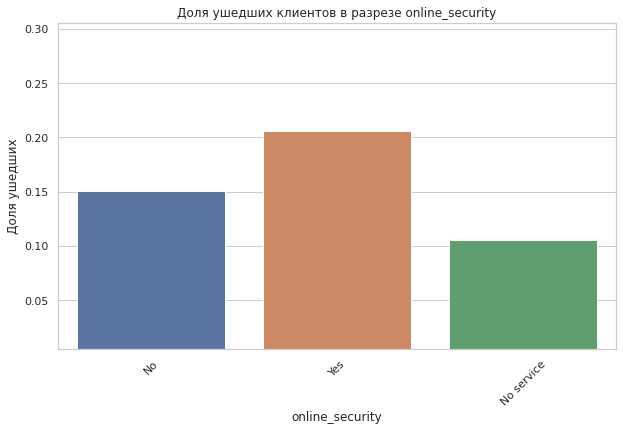


Таблица долей ушедших клиентов для online_security:


,online_security,terminated_ratio
1,Yes,0.205649
0,No,0.150372
2,No service,0.105056


In [38]:
plot_terminated_ratios(merged_df, 'online_security')

**Комментарий**: Клиенты с подключенной блокировкой чаще уходят. Может быть связано с ценой или недостаточной функциональностью услуги.

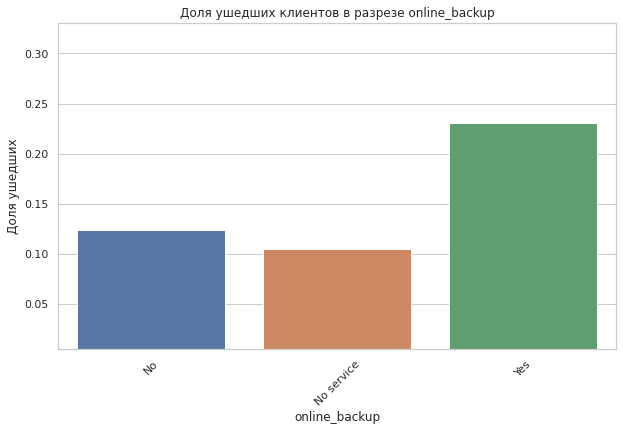


Таблица долей ушедших клиентов для online_backup:


,online_backup,terminated_ratio
2,Yes,0.230643
0,No,0.123381
1,No service,0.105056


In [39]:
plot_terminated_ratios(merged_df, 'online_backup')

**Комментарий**: Клиенты с подключенным резервным копированием уходят чаще, чем те, у кого этой услуги нет. Это может быть связано с ценой или неудовлетворенностью услугой.

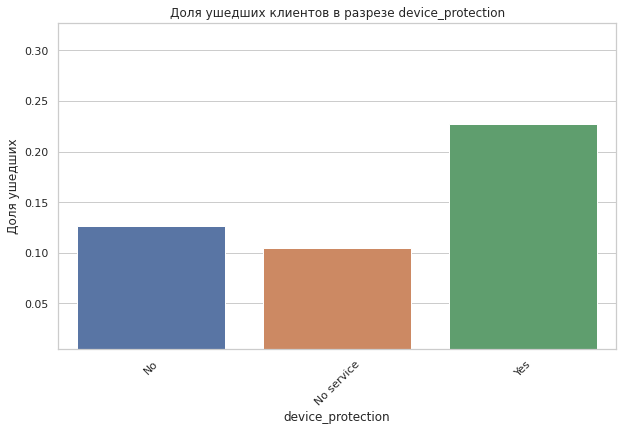


Таблица долей ушедших клиентов для device_protection:


,device_protection,terminated_ratio
2,Yes,0.227179
0,No,0.126333
1,No service,0.105056


In [40]:
plot_terminated_ratios(merged_df, 'device_protection')

**Комментарий**:  Клиенты с подключенной защитой устройств уходят чаще. Возможно, это связано с ценой или недостаточной функциональностью услуги.

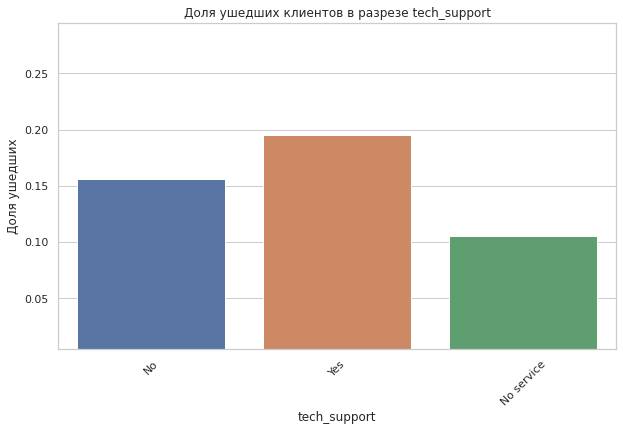


Таблица долей ушедших клиентов для tech_support:


,tech_support,terminated_ratio
1,Yes,0.194812
0,No,0.156349
2,No service,0.105056


In [41]:
plot_terminated_ratios(merged_df, 'tech_support')

**Комментарий**: Наличие выделенной линии технической поддержки значительно не влияет на отток клиентов. Наличие этой услуги повышает вероятность ухода клиента, но незначительно, так как, вероятно, услуга работает корректно. 

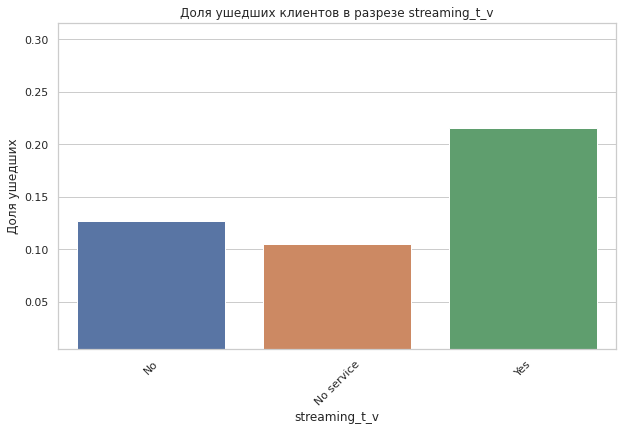


Таблица долей ушедших клиентов для streaming_t_v:


,streaming_t_v,terminated_ratio
2,Yes,0.215817
0,No,0.127046
1,No service,0.105056


In [42]:
plot_terminated_ratios(merged_df, 'streaming_t_v')

**Комментарий**: Наличие услуги стримингового вещания значительно повышает вероятность ухода клиента. Возможно, это связано с ценой или недостаточной функциональностью услуги.

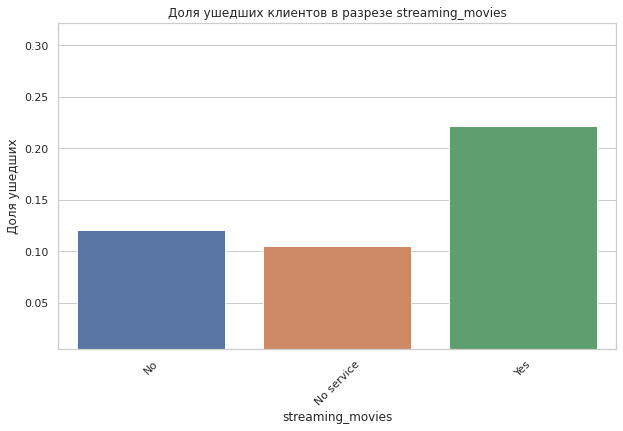


Таблица долей ушедших клиентов для streaming_movies:


,streaming_movies,terminated_ratio
2,Yes,0.221897
0,No,0.120287
1,No service,0.105056


In [43]:
plot_terminated_ratios(merged_df, 'streaming_movies')

**Комментарий**: Наличие услуги с каталогом фильмов значительно повышает вероятность ухода клиента. Возможно, это связано с ценой или недостаточной функциональностью услуги.

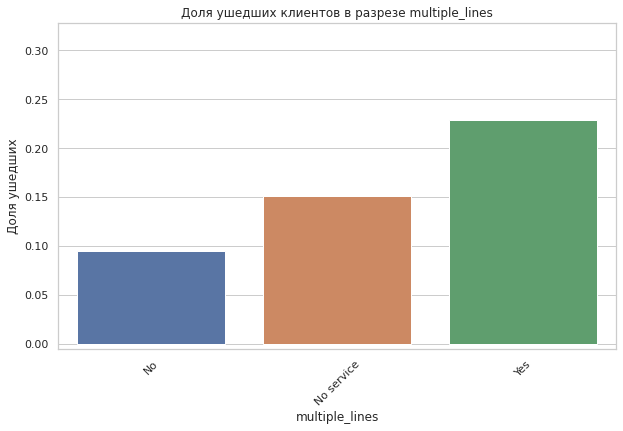


Таблица долей ушедших клиентов для multiple_lines:


,multiple_lines,terminated_ratio
2,Yes,0.228360
1,No service,0.151026
0,No,0.094451


In [44]:
plot_terminated_ratios(merged_df, 'multiple_lines')

**Комментарий**: Клиенты с подключением телефона к нескольким линиям одновременно уходят чаще. Это может быть связано с неудовлетворенностью услугой или её стоимостью.

### Корреляционный анализ

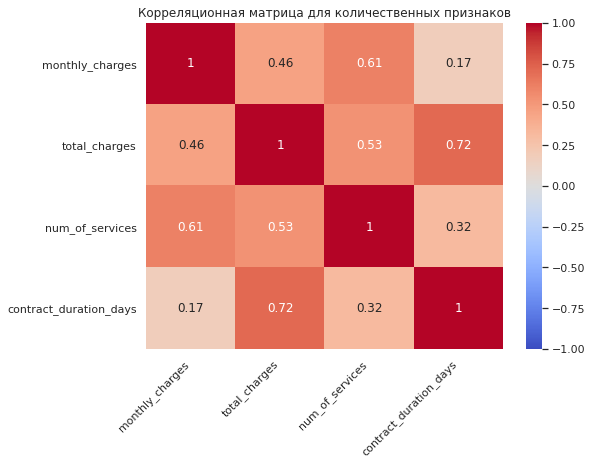

In [45]:
quantitative_features = ['monthly_charges', 'total_charges', 'num_of_services', 'contract_duration_days']
categorical_features = ['type', 'paperless_billing', 'payment_method', 'contract_terminated',
    'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service',
    'online_security', 'online_backup', 'device_protection', 'tech_support', 
    'streaming_t_v', 'streaming_movies', 'multiple_lines']

pearson_corr = merged_df[quantitative_features].corr(method='kendall')

plt.figure(figsize=(8, 6))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица для количественных признаков')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

**Комментарий**: 
1. monthly_charges сильно коррелирует с total_charges (0.61), что логично, так как общие расходы зависят от месячных платежей.
2. total_charges имеет высокую корреляцию с contract_duration_days (0.72), что тоже логично, поскольку долгосрочные контракты приводят к большему общему объему платежей.
3. num_of_services имеет умеренную корреляцию с total_charges (0.53), что ожидаемо, так как большее количество услуг ведет к большим затратам.

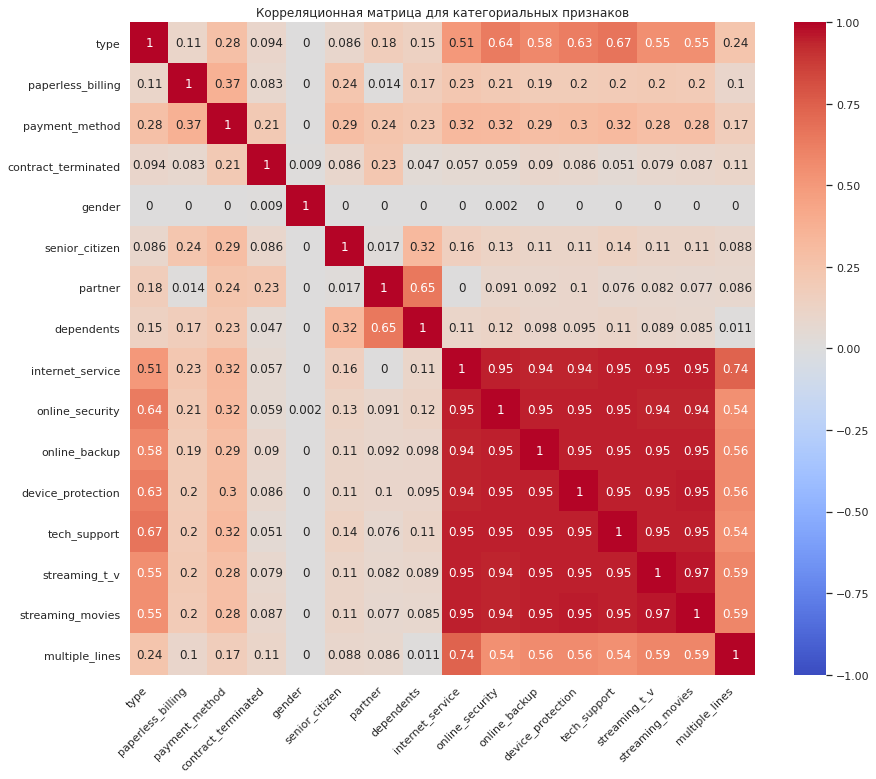

In [46]:
phik_matrix = merged_df[categorical_features].phik_matrix()

plt.figure(figsize=(14, 12))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица для категориальных признаков')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

**Комментарий**: 
1. Высокая корреляция между признаками internet_service, online_security, online_backup, device_protection, tech_support, streaming_t_v и streaming_movies. Это логично, так как все эти услуги могут быть выбраны вместе или в рамках одного пакета. Это может повлиять на обучение модели, так как мы в дальнейшем после анализа исключим наиболее незначимые признаки, вероятно, имеет смысл исключить весь пакет, оставив только internet_service.
2. Очень низкая корреляция между демографическими данными, такими как gender, senior_citizen, partner, dependents и другими признаками, что  может означать, что они меньше влияют на выбор услуг. Критично низкая корреляция между полом и другими признаками, в том числе целевым.
3. Тип оплаты: умеренная корреляция с интернет-услугами. Вероятно, что если человек использует почтовые чеки, то он с большей вероятностью не использует интернет.
4. Как ни странно, целевой признак (прекращение контракта) имеет небольшую корреляцию с остальными признаками, что указывает по сути на независимость этого события от большинства категорий. Вероятно, связи между признаками не совсем линейные и действуют в комплексе, поэтому логичнее использовать при обучении модели градиентного бустинга, дерева решений или случайный лес. 

### Исследовательский анализ данных: выводы

<div style="border: 1px solid black; padding: 10px; border-radius: 5px;"> 

1. **АНАЛИЗ КОЛИЧЕСТВЕННЫХ ПРИЗНАКОВ**. 
    - Месячные расходы (montly_charges): клиенты с высокими месячными расходами (выше 60) чаще остаются, и, наоборот, клиенты, разрывающие договор, чаще имеют более низкие месячные расходы.
    - Общие расходы (total_charges): те, у кого высокие общие расходы, чаще остаются - вероятно, это связано с тем, что они дольше времени пользуются услугами.
    - Количество услуг (num_of_services): те, кто использует меньше услуг (1-2), могут быть более склонны к разрыву, с увеличением же количества используемых услуг вероятность остаться увеличивается.
    - Продолжительность контракта (contract_duration_days): долгосрочные клиенты (более 1000 дней) чаще остаются, что указывает на лояльность, а новые клиенты чаще разрывают договор, что может сигнализировать о неудовлетворенности.
    
    
2. ***Корреляционный анализ количественных признаков***:
    - monthly_charges сильно коррелирует с total_charges (0.61), что логично, так как общие расходы зависят от месячных платежей.
    - total_charges имеет высокую корреляцию с contract_duration_days (0.72), что тоже логично, поскольку долгосрочные контракты приводят к большему общему объему платежей.
    - num_of_services имеет умеренную корреляцию с total_charges (0.53), что ожидаемо, так как большее количество услуг ведет к большим затратам.
    
    
3. **АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ**.
    - Тип оплаты. Two year и one year: самая высокая доля ушедших клиентов, что может указывать на трудности с удержанием клиентов на более длительных контрактах. Cамая низкая доля ушедших клиентов при оплате Month-to-month, так что, вероятно, клиенты, выбирающие эту опцию, как правило, остаются дольше, возможно из-за гибкости и отсутствия долгосрочных обязательств.
    - Демографические признаки gender, senior_citizen, partner, dependents. Нет корреляции между полом и разрывом контракта, вероятность разрыва повышается у пенсионеров и у людей с семейными обязательствами (наличие партнера и иждивенцов). 
    - Наличие интернет-услуг и телефонных услуг само по себе уже повышает вероятность ухода клиента, что может быть связано с качеством/ценой оказываемых услуг. 
    
    
4. ***Корреляционный анализ категориальных признаков***:
    - Высокая корреляция между признаками internet_service, online_security, online_backup, device_protection, tech_support, streaming_t_v и streaming_movies. Это логично, так как все эти услуги могут быть выбраны вместе или в рамках одного пакета. Это может повлиять на обучение модели, так как мы в дальнейшем после анализа исключим наиболее незначимые признаки, вероятно, имеет смысл исключить весь пакет, оставив только internet_service.
    - Очень низкая корреляция между демографическими данными, такими как gender, senior_citizen, partner, dependents и другими признаками, что может означать, что они меньше влияют на выбор услуг. Критично низкая корреляция между полом и другими признаками, в том числе целевым.
    - Целевой признак (прекращение контракта) имеет небольшую корреляцию с остальными признаками, что указывает по сути на линейную независимость этого события от большинства категорий. Вероятно, связи между признаками не совсем линейные и действуют в комплексе, поэтому логичнее использовать при обучении модели градиентного бустинга, дерева решений или случайный лес.
    
</div>

## Подготовка данных для обучения

### Отбор признаков для обучения

Исследовательский анализ позволил нам определить наиболее значимые и незначимые признаки: на данном шаге мы устраним неинформативные признаки или же излишние, дублирующие. К таковым можно отнести gender и полный пакет интернет-услуг (оставим только internet_service, так как его наличие сильно коррелирует со всем пакетом). Также исключаем признаки begin_date и end_date, так как по сути они подсказывают целевой признак. 

In [47]:
columns_to_drop = ['begin_date', 'end_date', 'gender', 'online_security', 'online_backup', 
                   'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies']

new_df = merged_df.drop(columns=columns_to_drop)
new_df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,internet_service,multiple_lines,num_of_services,contract_duration_days,contract_terminated
customer_id,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,No,Yes,No,DSL,No service,1,31,No
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,No,No,No,DSL,No,1,1036,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,No,No,No,DSL,No,1,123,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,No,No,No,DSL,No service,2,1371,No
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,No,No,No,Fiber optic,No,0,153,No


**Комментарий**: Удаление избыточных признаков произошло корректно. 

### Создание выборок 

In [48]:
features = new_df.drop(['contract_terminated'], axis=1)
target = new_df['contract_terminated']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(f"Размер тренировочного корпуса: {X_train.shape}")
print(f"Размер тестового корпуса: {X_test.shape}")

Размер тренировочного корпуса: (5279, 12)
Размер тестового корпуса: (1760, 12)


**Комментарий**: Разделение на выборки произошло корректно, размерность соблюдена.

### Пайплайн для подготовки данных

In [49]:
categorical_features = ['type', 'paperless_billing', 'payment_method', 
                        'senior_citizen', 'partner', 'dependents', 'internet_service', 'multiple_lines']
numerical_features = ['monthly_charges', 'total_charges', 'num_of_services', 'contract_duration_days']

In [50]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

data_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_train_processed = data_pipeline.fit_transform(X_train)
X_test_processed = data_pipeline.transform(X_test)

**Комментарий**: На данном этапе мы отобрали количественные и категориальные признаки, создали пайплайн для подготовки данных для обучения, применили его на тренировочной и тестовых выборках. Но для обучения общий пайплайн создавать не будем, чтобы можно было иметь больше возможностей для настройки параметров у каждой модели. 

### Подготовка данных для обучения: выводы

<div style="border: 1px solid black; padding: 10px; border-radius: 5px;"> 

Исследовательский анализ позволил нам определить наиболее значимые и незначимые признаки: на данном шаге мы устранили неинформативные признаки или же излишние, дублирующие:
    
- gender;
    
- полный пакет интернет-услуг (оставили только internet_service, так как его наличие сильно коррелирует со всем пакетом);

- begin_date и end_date, так как по сути они подсказывают целевой признак.
    
На данном этапе мы отобрали количественные и категориальные признаки, создали пайплайн для подготовки данных для обучения, создали тренировочную и тестовую выборки (3:1), подготовили данные. 
    
</div>

## Обучение моделей

На данном этапе мы обучим три модели и подберем для них разные гиперпараметры: LogisticRegression, LightGBM, DecisionTreeClassifier. Выбор последних двух моделей обусловлен тем, что, судя по исследовательскому анализу, между признаки больше нелинейных связей, чем линейных. Для кросс-валидации и тестирования модели будет использоваться метрика AUC-ROC, как наиболее точная при оценке моделей классификации, тем более при дисбалансе классов. Заказчиком был поставлен порог метрики - **0.85**.

### LogisticRegression

In [51]:
logreg = LogisticRegression(class_weight='balanced')
logreg_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear']
}

random_logreg = RandomizedSearchCV(
    logreg, 
    logreg_params, 
    cv=5, 
    n_iter=10, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    verbose = 0
)
random_logreg.fit(X_train_processed, y_train)

best_logreg = random_logreg.best_estimator_

print("Лучшие параметры для Logistic Regression:", random_logreg.best_params_)
print("Наилучший AUC-ROC для Logistic Regression:", random_logreg.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшие параметры для Logistic Regression: {'solver': 'liblinear', 'C': 0.1}
Наилучший AUC-ROC для Logistic Regression: 0.7601153679857243


### LightGBM

In [52]:

from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE)
lgbm_params = {
    'num_leaves': [16, 31, 50],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 500]
}

random_lgbm = RandomizedSearchCV(
    lgbm, 
    lgbm_params, 
    cv=3, 
    n_iter=10, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE, 
    verbose = 0
)
random_lgbm.fit(X_train_processed, y_train)

best_lgbm = random_lgbm.best_estimator_
print("Лучшие параметры для LightGBM:", random_lgbm.best_params_)
print("Наилучший AUC-ROC для LightGBM:", random_lgbm.best_score_)

[LightGBM] [Info] Number of positive: 551, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 551, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 552, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 551, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 551, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 552, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 551, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 551, number of negative: 2968
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Inf

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 552, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 551, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] [binary:Boos

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 551, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 552, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] [binary:Boos

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 551, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 552, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 551, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 551, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] [binary:Boos

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 552, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 551, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] [binary:Boos

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 551, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 552, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] [binary:Boos

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 551, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 551, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 552, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 551, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 551, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 552, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 551, number of negative: 2968
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 551, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 552, number of negative: 2968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 827, number of negative: 4452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 743
[LightGBM] [Info] Number of data points in the train set: 5279, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Лучшие параметры для LightGBM: {'num_leaves': 16, 'n_estimators': 200, 'learning_rate': 0.3}
Наилучший AUC-ROC для LightGBM: 0.8638512601699638


### DecisionTreeClassifier

In [53]:
dtree = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dtree_params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_dtree = RandomizedSearchCV(
    dtree, 
    dtree_params, 
    cv=3, 
    n_iter=10, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    verbose = 0
)
random_dtree.fit(X_train_processed, y_train)

best_dtree = random_dtree.best_estimator_
print("Лучшие параметры для Decision Tree:", random_dtree.best_params_)
print("Наилучший AUC-ROC для Decision Tree:", random_dtree.best_score_)

Лучшие параметры для Decision Tree: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 3}
Наилучший AUC-ROC для Decision Tree: 0.7456954698751254


### Обучение моделей: выводы

In [54]:
print("Наилучший AUC-ROC для Logistic Regression:", random_logreg.best_score_)
print("Наилучший AUC-ROC для LightGBM:", random_lgbm.best_score_)
print("Наилучший AUC-ROC для Decision Tree:", random_dtree.best_score_)

Наилучший AUC-ROC для Logistic Regression: 0.7601153679857243
Наилучший AUC-ROC для LightGBM: 0.8638512601699638
Наилучший AUC-ROC для Decision Tree: 0.7456954698751254


<div style="border: 1px solid black; padding: 10px; border-radius: 5px;"> 

На данном этапе мы обучили три модели и подберем для них разные гиперпараметры: LogisticRegression, LightGBM, DecisionTreeClassifier. Для кросс-валидации и тестирования модели была использована метрика AUC-ROC, как наиболее точная при оценке моделей классификации, тем более при дисбалансе классов. Заказчиком был поставлен порог метрики - **0.85**. Наилучше всего на кросс-валидации себя показала модель **LightGBM с параметрами {'num_leaves': 16, 'n_estimators': 200, 'learning_rate': 0.3}**, её показатель оказался выше заданного порога.
    
</div>

## Тестирование лучшей модели

### Тест модели

In [55]:
y_predict_proba = best_lgbm.predict_proba(X_test_processed)[:, 1]
roc_auc = roc_auc_score(y_test, y_predict_proba)
print(f"AUC_ROC-метрика на тестовом наборе: {roc_auc:.4f}")

y_pred = best_lgbm.predict(X_test_processed)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy модели: {accuracy:.4f}')

AUC_ROC-метрика на тестовом наборе: 0.9175
Accuracy модели: 0.9017


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


**Комментарий**: Выбранная на кросс-валидации модель на тестовой выборке показала результат выше необходимого порога, а также высокую точность. Проанализируем её показатели более подробно.

### Анализ метрик

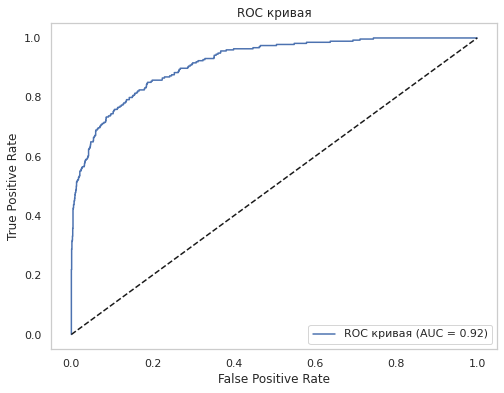

In [56]:
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test_binary, y_predict_proba)
roc_auc = roc_auc_score(y_test_binary, y_predict_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc='lower right')
plt.grid()
plt.show()

**Комментарий**: ROC-кривая действительно кривая и находится высоко от линии случайного угадывания, то есть модель очевидно имеет высокую точность классификации и хорошую способность различать классы, что делает ее пригодной для использования в бизнес-целях.

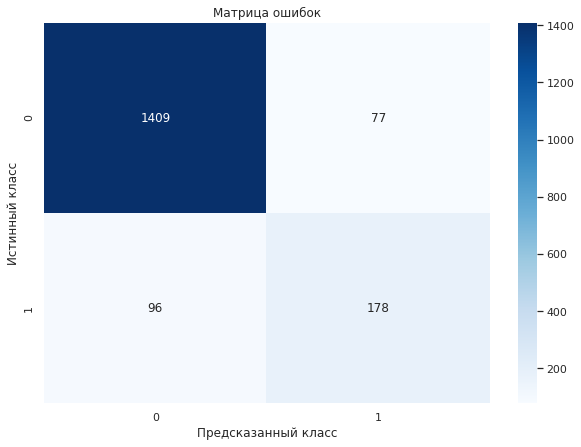

In [57]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

**Комментарий**: 
1. FP (77): Уровень ложных срабатываний не очень высок, но может быть проблематичным, так как это создает "ложную тревогу" — клиенты остаются, а модель предсказывает, что они разорвут договор.
2. FN (96): Относительно высокий уровень пропущенных срабатываний. Это может быть критично, так как пропущенные случаи разрыва договора могут иметь серьезные последствия: компания, наоборот, преследует цель предотвратить разрыв.

Для коррекции работы модели в дальнейшем можно использовать добавление новых признаков или пересмотр текущих, тюннинг модели (например, корректировку порога для определения классов, чтобы снизить FN). 

### SHAP-анализ признаков

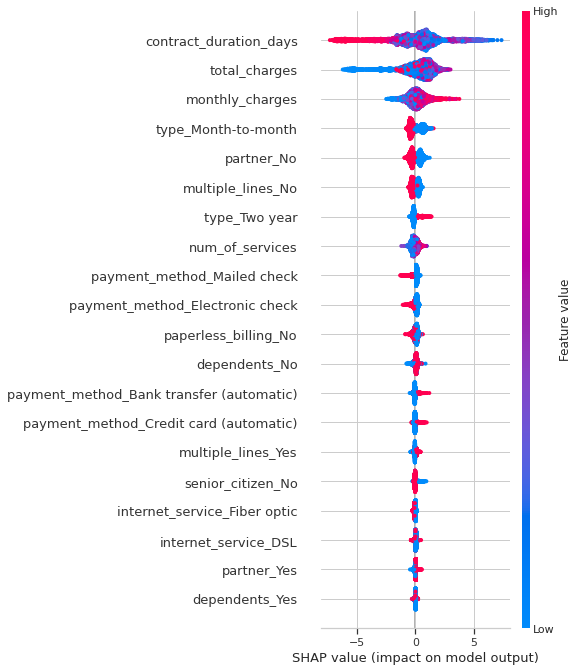

In [58]:
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_features = list(cat_encoder.get_feature_names_out(categorical_features))

feature_names = numerical_features + cat_features

X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)

explainer = shap.Explainer(best_lgbm)
shap_values = explainer(X_train_processed_df)
shap.summary_plot(shap_values, X_train_processed_df, feature_names=feature_names)

**Комментарий**: 
Наиболее влиятельными оказались количественные признаки contract_duration_days, total_charges и monthly_charges. 
- contract_duration_days: более продолжительные контракты могут уменьшать вероятность оттока, более короткие - повышать вероятность разрыва;
- total_charges: как ни странно, более низкая сумма общих расходов уменьшает вероятность оттока клиента, но не наоборот;
- monthly_charges: более высокие ежемесячные расходы могут увеличивать отток.

Категориальные: type_Month-to-month - наличие или отсутствие оплаты помесячно показательно для определения класса клиента.

Бинарные: отсутствие партнера и неиспользование мультиканальности также серьезно помогают модели в классификации клиентов. 

### Тестирование лучшей модели: выводы

<div style="border: 1px solid black; padding: 10px; border-radius: 5px;"> 

Выбранная на кросс-валидации модель **LightGBM с параметрами {'num_leaves': 16, 'n_estimators': 200, 'learning_rate': 0.3}** на тестовой выборке показала результат выше необходимого порога (>0.85), а также высокую точность. Также сделаны следующие наблюдения:
1. ROC-кривая показывает, что модель очевидно имеет высокую точность классификации и хорошую способность различать классы, что делает ее пригодной для использования в бизнес-целях.
    

2. Модель хорошо определяет классы, но ошибки есть: 
    - FP (77 из 1760): уровень ложных срабатываний не очень высок, но может быть проблематичным, так как это создает "ложную тревогу" — клиенты остаются, а модель предсказывает, что они разорвут договор.
    - FN (96 из 1760): относительно высокий уровень пропущенных срабатываний, что может быть критично, так как пропущенные случаи разрыва договора могут иметь серьезные последствия, тем более если компания, наоборот, преследует цель предотвратить разрыв.

    
3. Наиболее влиятельными оказались количественные признаки contract_duration_days, total_charges и monthly_charges.
    - contract_duration_days: более продолжительные контракты могут уменьшать вероятность оттока, более короткие - повышать вероятность разрыва;
    - total_charges: как ни странно, более низкая сумма общих расходов уменьшает вероятность оттока клиента, но не наоборот;
monthly_charges: более высокие ежемесячные расходы могут увеличивать отток.

Категориальные: type_Month-to-month - наличие или отсутствие оплаты помесячно показательно для определения класса клиента.

Бинарные: отсутствие партнера и неиспользование мультиканальности также серьезно помогают модели в классификации клиентов.
    
</div>

## Общий вывод

<div style="border: 1px solid black; padding: 10px; border-radius: 5px;"> 

**ЗАДАЧА ПРОЕКТА**
    
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Необходимо было построить модель, которая будет предсказывать, разорвёт ли абонент договор.
    
</div>

<div style="border: 1px solid black; padding: 10px; border-radius: 5px;"> 

**ХОД ПРОЕКТА**
    
1. **Загрузка данных**. 

По выгруженным датасетам contract_new.csv, personal_new.csv, internet_new.csv, phone_new.csv были сделаны следующие выводы:
- Есть проблемы с оформлением: потребовалась замена заголовков на корректный змеиный регистр.
- Все датасеты достаточно объемные, по несколько тысяч записей.
- Нет пропусков (вероятно, они образуются при объединении датасетов). 
- Не все данные представлены в нужном типе, требуется замена типа данных.
    
2.  **Предобработка данных**. 
- Все 4 датасета приведены к единому оформлению, змеиному регистру.
- Заменили в датасете contract тип данных на корректный, в датасете personal привели признак senior_citizen к единообразию в оформлении.
- Объединение датасетов в единый произошло успешно, все данные сохранены и корректно отображаются: объединение произошло по принципу outer, так как нам было важно сохранить информацию о всех клиентах вообще.
- Все пропуски устранены, объединенный датасет заполнен. Большинство пропусков в объединенном датасете образовались в связи с тем, что часть клиентов не использует услуги, такие пропуски были заполнены заглушками "No service".
- Явные дубликаты (4) были удалены из объединенного датасета, неявные обнаружены не были. 
    
3. **Исследовательский анализ данных**.
- ***Количественные признаки***: 
    - ***Месячные расходы (montly_charges)***: клиенты с высокими месячными расходами (выше 60) чаще остаются, и, наоборот, клиенты, разрывающие договор, чаще имеют более низкие месячные расходы. monthly_charges сильно коррелирует с total_charges (0.61), что логично, так как общие расходы зависят от месячных платежей.
    - ***Общие расходы (total_charges)***: те, у кого высокие общие расходы, чаще остаются - вероятно, это связано с тем, что они дольше времени пользуются услугами. total_charges имеет высокую корреляцию с contract_duration_days (0.72), что тоже логично, поскольку долгосрочные контракты приводят к большему общему объему платежей.
    - ***Количество услуг (num_of_services)***: те, кто использует меньше услуг (1-2), могут быть более склонны к разрыву, с увеличением же количества используемых услуг вероятность остаться увеличивается. num_of_services имеет умеренную корреляцию с total_charges (0.53), что ожидаемо, так как большее количество услуг ведет к большим затратам.
    - ***Продолжительность контракта (contract_duration_days)***: долгосрочные клиенты (более 1000 дней) чаще остаются, что указывает на лояльность, а новые клиенты чаще разрывают договор, что может сигнализировать о неудовлетворенности.

    
- ***Категориальные признаки***:
    - ***Тип оплаты***. Two year и one year: самая высокая доля ушедших клиентов, что может указывать на трудности с удержанием клиентов на более длительных контрактах. Cамая низкая доля ушедших клиентов при оплате Month-to-month, так что, вероятно, клиенты, выбирающие эту опцию, как правило, остаются дольше, возможно из-за гибкости и отсутствия долгосрочных обязательств.
    - ***Демографические признаки gender, senior_citizen, partner, dependents***. Нет корреляции между полом и разрывом контракта, вероятность разрыва повышается у пенсионеров и у людей с семейными обязательствами (наличие партнера и иждивенцов). Очень низкая корреляция между демографическими данными, такими как gender, senior_citizen, partner, dependents и другими признаками, что может означать, что они меньше влияют на выбор услуг. Критично низкая корреляция между полом и другими признаками, в том числе целевым.
    - ***Наличие интернет-услуг и телефонных услуг*** само по себе уже повышает вероятность ухода клиента, что может быть связано с качеством/ценой оказываемых услуг. Высокая корреляция между признаками internet_service, online_security, online_backup, device_protection, tech_support, streaming_t_v и streaming_movies. Это логично, так как все эти услуги могут быть выбраны вместе или в рамках одного пакета.
    - ***Целевой признак (прекращение контракта)*** имеет небольшую корреляцию с остальными признаками, что указывает по сути на линейную независимость этого события от большинства категорий. Вероятно, связи между признаками не совсем линейные и действуют в комплексе.
    
    
4. **Подготовка данных для обучения**.

Исследовательский анализ позволил нам определить наиболее значимые и незначимые признаки: на данном шаге мы устранили неинформативные признаки или же излишние, дублирующие:
- gender;
- полный пакет интернет-услуг (оставили только internet_service, так как его наличие сильно коррелирует со всем пакетом);
- begin_date и end_date, так как по сути они подсказывают целевой признак.

На данном этапе мы отобрали количественные и категориальные признаки, создали пайплайн для подготовки данных для обучения, создали тренировочную и тестовую выборки (3:1), подготовили данные.
    
    
5. **Обучение моделей**.

На данном этапе мы обучили три модели и подобрали для них разные гиперпараметры: LogisticRegression, LightGBM, DecisionTreeClassifier. Для кросс-валидации и тестирования модели была использована метрика AUC-ROC, как наиболее точная при оценке моделей классификации, тем более при дисбалансе классов. Заказчиком был поставлен порог метрики - **0.85**. Наилучше всего на кросс-валидации себя показала модель **LightGBM с параметрами {'num_leaves': 16, 'n_estimators': 200, 'learning_rate': 0.3}**, её показатель оказался выше заданного порога.
    
6. **Тестирование лучшей модели**.
    
Выбранная на кросс-валидации модель **LightGBM с параметрами {'num_leaves': 16, 'n_estimators': 200, 'learning_rate': 0.3}** на тестовой выборке показала результат выше необходимого порога (>0.85), а также высокую точность. Также сделаны следующие наблюдения:
- ROC-кривая показывает, что модель очевидно имеет высокую точность классификации и хорошую способность различать классы, что делает ее пригодной для использования в бизнес-целях.
- Модель хорошо определяет классы, но ошибки есть: 
    - FP (77 из 1760): уровень ложных срабатываний не очень высок, но может быть проблематичным, так как это создает "ложную тревогу" — клиенты остаются, а модель предсказывает, что они разорвут договор.
    - FN (96 из 1760): относительно высокий уровень пропущенных срабатываний, что может быть критично, так как пропущенные случаи разрыва договора могут иметь серьезные последствия, тем более если компания, наоборот, преследует цель предотвратить разрыв.
- Наиболее влиятельными оказались количественные признаки contract_duration_days, total_charges и monthly_charges, а также категориальный признак type_Month-to-month и бинарные partner_No, multiple_lines_NO.
    
</div>

<div style="border: 3px solid black; padding: 10px; border-radius: 5px;"> 

**ИТОГОВАЯ РЕКОМЕНДАЦИЯ ДЛЯ БИЗНЕСА**
    
1. Обратить внимание на качество и стоимость оказываемых интернет-услуг: их использование повышает вероятность оттока клиентов.
2. Возможно, стоит скорректировать политику типа оплаты: оплата 1 раз в 1-2 года повышает вероятность оттока, нежели ежемесячная оплата.     
3. Для коррекции работы предложенной нами модели (LightGBM с параметрами {'num_leaves': 16, 'n_estimators': 200, 'learning_rate': 0.3}) в дальнейшем можно использовать добавление новых признаков или пересмотр текущих, тюннинг модели (например, корректировку порога для определения классов, чтобы снизить FN, пропущенные срабатывания).

</div>